Se extraen los datos del archivo y se muestran los datos involucrados

In [36]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# archivo
archivo = "Flujo2019.mat"
datos = scipy.io.loadmat(archivo)

#  datos
datos.keys()

C:\Users\ST\AppData\Roaming\Python\Python311\site-packages\scipy\io\matlab\_mio.py:235: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Considerscipy.io.matlab.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


dict_keys(['__header__', '__version__', '__globals__', 'None', 'FlujoAgosto', 'FlujoDiciembre', 'FlujoJulio', 'FlujoJunio', 'FlujoNoviembre', 'FlujoOctubre', 'FlujoSeptiembre', '__function_workspace__'])

 FlujoJulio es un arreglo que representa los valores de consumo de agua durante julio de 2020. 
 
 Para utilizar estos datos en la red neuronal necesitamos normalizar, es decir, un valor entre entre $[0,1)$, ésto para ver de una mejor manera el comportamiento del flujo.

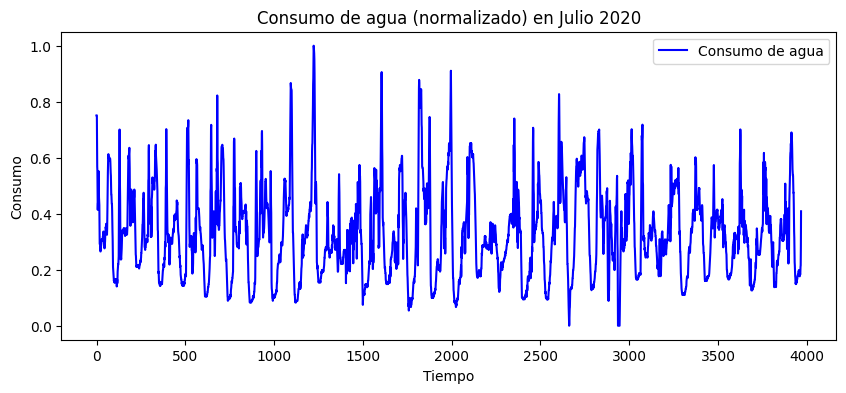

In [37]:
flujo = datos.get("FlujoJulio").flatten()

# normalizar cada uno de los datos 
min = np.min(flujo)
max = np.max(flujo)
flujo_norm = (flujo - min) / (max - min)

# representación de los datos ya normalizados
plt.figure(figsize=(10, 4))
plt.plot(flujo_norm, label="Consumo de agua", color='b')
plt.xlabel("Tiempo")
plt.ylabel("Consumo")
plt.title("Consumo de agua (normalizado) en Julio 2020")
plt.legend()
plt.show()


Entrenamiento: $3174$ muestras, corresponde al $80\%$ de los datos

Prueba: $793$ muestras, corresponde al $20\%$ de los datos

In [38]:
# dvidir los datos 
equipo = int(0.8 * len(flujo_norm))
x_entrena = flujo_norm[:equipo]
x_prueba = flujo_norm[equipo:]

y_entrena = np.roll(x_entrena, -1)[:-1]  
y_prueba = np.roll(x_prueba, -1)[:-1]

x_entrena.shape, y_entrena.shape, x_prueba.shape, y_prueba.shape

x_entrena = x_entrena[:-1]

Época 0, Error: 0.03541030857773625
Época 100, Error: 0.019169776412716517
Época 200, Error: 0.017661395490680454
Época 300, Error: 0.017435919034797846
Época 400, Error: 0.017324908456926337
Época 500, Error: 0.01722537656247845
Época 600, Error: 0.017128170949651248
Época 700, Error: 0.017032441870815502
Época 800, Error: 0.016938075456632798
Época 900, Error: 0.016845023862519


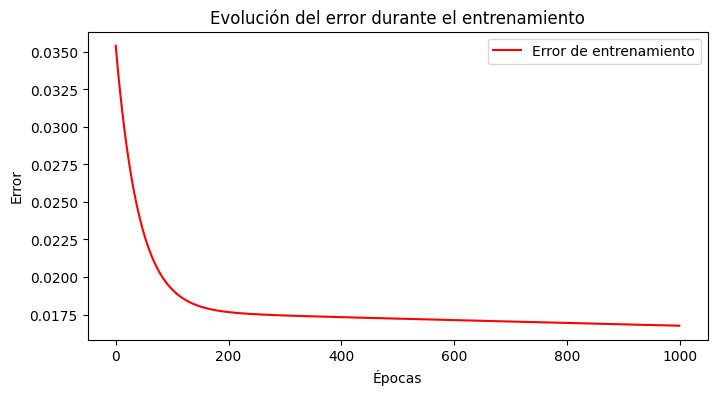

In [39]:
# Red Neuronal
class Red_N:
    def __init__(self, alpha=0.01, epocas=1000):
        self.alpha = alpha  
        self.epocas = epocas
        self.w1, self.w2, self.w3, self.w4 = np.random.randn(4)  # pesos
        self.b2, self.b4, self.by = np.random.randn(3)  # sesgos

    def sigmoide(self, z):
        return 1 / (1 + np.exp(-z))

    def d_sigmoide(self, z):
        s = self.sigmoide(z)
        return s * (1 - s)

    def entrena(self, x, y):
        errores = []
        for epoch in range(self.epocas):
            error_total_prom = 0
            
            # Forward pass
            z2 = self.w2 * x + self.b2
            h1 = self.sigmoide(z2)
            
            z4 = self.w4 * x + self.b4
            h2 = self.sigmoide(z4)
            
            y_pred = self.w1 * h1 + self.w3 * h2 + self.by
            
            # Error
            error = 0.5 * (y_pred - y) ** 2
            error_total_prom = np.mean(error)

            
            dE_dy = y_pred - y
            dE_dw1 = dE_dy * h1
            dE_dw3 = dE_dy * h2
            dE_dby = dE_dy

            dE_dh1 = dE_dy * self.w1
            dE_dh2 = dE_dy * self.w3

            dE_dw2 = dE_dh1 * self.d_sigmoide(z2) * x
            dE_db2 = dE_dh1 * self.d_sigmoide(z2)

            dE_dw4 = dE_dh2 * self.d_sigmoide(z4) * x
            dE_db4 = dE_dh2 * self.d_sigmoide(z4)

            # Actualización de parámetros
            self.w1 -= self.alpha * np.mean(dE_dw1)
            self.w3 -= self.alpha * np.mean(dE_dw3)
            self.by -= self.alpha * np.mean(dE_dby)

            self.w2 -= self.alpha * np.mean(dE_dw2)
            self.b2 -= self.alpha * np.mean(dE_db2)

            self.w4 -= self.alpha * np.mean(dE_dw4)
            self.b4 -= self.alpha * np.mean(dE_db4)

            errores.append(error_total_prom)
            
            # Mostrar progreso
            if epoch % 100 == 0:
                print(f"Época {epoch}, Error: {error_total_prom}")

        return errores

    def prediccion(self, x):
        h1 = self.sigmoide(self.w2 * x + self.b2)
        h2 = self.sigmoide(self.w4 * x + self.b4)
        return self.w1 * h1 + self.w3 * h2 + self.by


# Crear y entrenar la red neuronal optimizada
nn_opt = Red_N(alpha=0.01, epocas=1000)
h = nn_opt.entrena(x_entrena, y_entrena)

# Graficar la evolución del error
plt.figure(figsize=(8, 4))
plt.plot(h, label="Error de entrenamiento", color='r')
plt.xlabel("Épocas")
plt.ylabel("Error")
plt.title("Evolución del error durante el entrenamiento")
plt.legend()
plt.show()





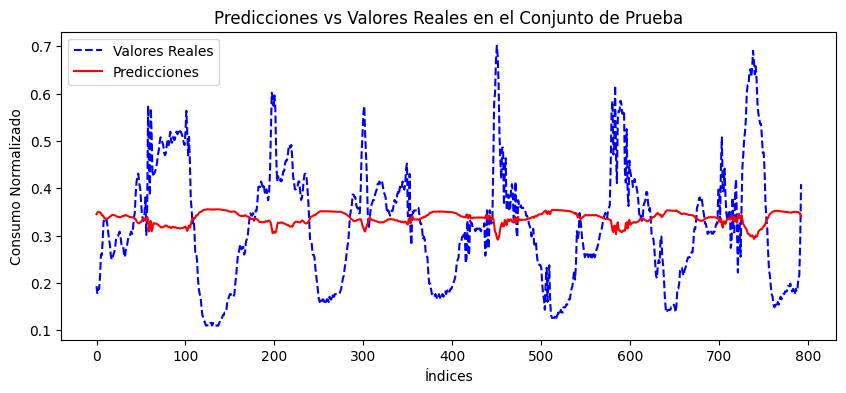

In [40]:
# Evaluar la red neuronal en datos de prueba
y_pred_prueba = nn_opt.prediccion(x_prueba[:-1])  # Ajustar longitud para comparación

# Graficar predicciones vs valores reales
plt.figure(figsize=(10, 4))
plt.plot(y_prueba, label="Valores Reales", color='b', linestyle="dashed")
plt.plot(y_pred_prueba, label="Predicciones", color='r')
plt.xlabel("Índices")
plt.ylabel("Consumo Normalizado")
plt.title("Predicciones vs Valores Reales en el Conjunto de Prueba")
plt.legend()
plt.show()